In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

In [2]:
# --- 1. DATA LOADING AND CLEANING ---
df = pd.read_csv('imdb_cleaned.csv')
df.columns

Index(['startYear', 'runtimeMinutes', 'totalCredits', 'numRegions',
       'ratingCount', 'castNumber', 'companiesNumber', 'writerCredits',
       'directorsCredits', 'totalNominations', 'totalMedia', 'totalReviews',
       'Asia', 'Africa', 'Europe', 'North America', 'South America', 'Oceania',
       'Continent Unknown', 'genre1', 'genre2', 'genre3', 'movie', 'short',
       'tvEpisode', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'tvShort',
       'tvSpecial', 'video', 'videoGame', 'rating_bin'],
      dtype='object')

In [3]:
# Define mapping dictionary for ratings
rating_mapping = {
    0: "[1, 5)",
    1: "[5, 6)",
    2: "[6, 7)",
    3: "[7, 8)",
    4: "[8, 9)",
    5: "[9, 10]"
}

# Apply mapping
df['rating_bin'] = df['rating_bin'].map(rating_mapping)

In [4]:
# --- 2. FEATURE SELECTION ---
numerical_cols = [
    'startYear', 'runtimeMinutes', 'totalCredits',
    'numRegions', 'ratingCount', 'castNumber',
    'companiesNumber', 'writerCredits', 'directorsCredits',
    'totalNominations', 'totalMedia', 'totalReviews',
]

titletype_cols = [
    'movie', 'short', 'tvEpisode',
    'tvSeries', 'tvSpecial', 'video',
]

region_cols = [
    'Asia', 'Africa', 'Europe',
    'North America', 'South America', 'Oceania',
    'Continent Unknown'
]

genre_cols = ['genre1', 'genre2', 'genre3']

# All features being used for the model
selected_features = numerical_cols + region_cols + genre_cols + titletype_cols
to_scale = numerical_cols + region_cols + genre_cols # Features to pass through StandardScaler

In [5]:
# --- 3. TRAIN-TEST-VAL SPLIT ---
X = df.drop(columns=['rating_bin'])
y = df['rating_bin']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

In [7]:
# --- 4. PREPROCESSING (LOG & SCALE) ---
to_log = ['numRegions', 'ratingCount', 'companiesNumber', 'totalNominations', 'totalMedia', 'totalReviews']

for col in to_log:
    X_train[col] = np.log1p(X_train[col].fillna(0).clip(lower=0))
    X_val[col] = np.log1p(X_val[col].fillna(0).clip(lower=0))
    X_test[col] = np.log1p(X_test[col].fillna(0).clip(lower=0))

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale])
X_val[to_scale] = scaler.transform(X_val[to_scale])
X_test[to_scale] = scaler.transform(X_test[to_scale])

In [8]:
# --- 5. PREPARE MULTI-INPUT FORMAT ---
def format_input(data_df):
    return {
        'numerical': data_df[numerical_cols].values,
        'region': data_df[region_cols].values,
        'genre': data_df[genre_cols].values,
        'titletype': data_df[titletype_cols].values
    }

X_test_dict = format_input(X_test)
X_train_dict = format_input(X_train)

# Combine for SHAP (Matrix format)
X_train_combined = np.hstack([X_train_dict[k] for k in ['numerical', 'region', 'genre', 'titletype']])
X_test_combined = np.hstack([X_test_dict[k] for k in ['numerical', 'region', 'genre', 'titletype']])

feature_names = numerical_cols + region_cols + genre_cols + titletype_cols
class_names = ["[1, 5)", "[5, 6)", "[6, 7)", "[7, 8)", "[8, 9)", "[9, 10]"]

In [9]:
# --- 6. LOAD MODEL ---
model_rating = keras.models.load_model("neural_net_rating.keras")

In [10]:
# --- 7. SHAP EXPLAINER SETUP ---
def predict_wrapper(x):
    return model_rating.predict({
        'numerical': x[:, :len(numerical_cols)],
        'region': x[:, len(numerical_cols):len(numerical_cols)+len(region_cols)],
        'genre': x[:, len(numerical_cols)+len(region_cols):len(numerical_cols)+len(region_cols)+len(genre_cols)],
        'titletype': x[:, len(numerical_cols)+len(region_cols)+len(genre_cols):]
    }, verbose=0)

# Sample background data for speed
background_data = shap.sample(X_train_combined, 100)
explainer = shap.KernelExplainer(predict_wrapper, background_data)

In [16]:
# --- 8. EXPLAIN INSTANCE 1 ---
instance_idx = 1 
instance = X_test_combined[instance_idx].reshape(1, -1)

# Get Predictions
pred_probs = predict_wrapper(instance)
predicted_label_idx = np.argmax(pred_probs)
true_label_string = y_test.iloc[instance_idx]
try:
    # Find which index in class_names matches the string from y_test
    true_label_idx = class_names.index(true_label_string)
except ValueError:
    # Fallback if mapping is slightly different
    true_label_idx = 0

# Calculate SHAP Values
shap_results = explainer.shap_values(instance)

  0%|          | 0/1 [00:00<?, ?it/s]

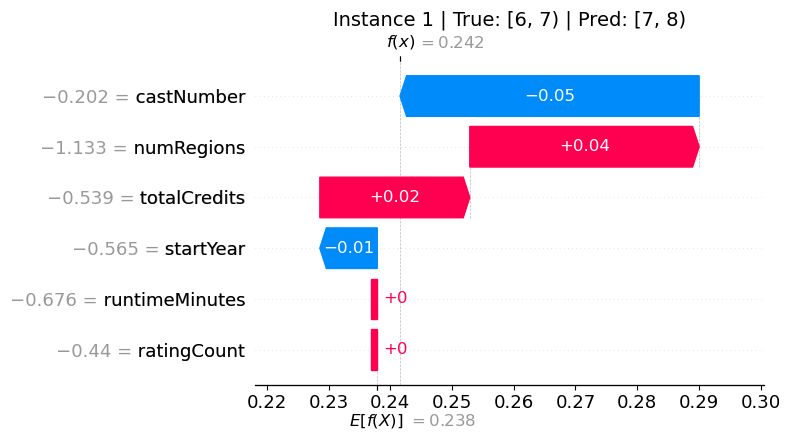

In [18]:
# --- 9. ROBUST ALIGNMENT & PLOTTING (FINAL FIX) ---
import matplotlib.pyplot as plt

# 1. Determine how many classes SHAP actually returned
# This prevents the "Index 3 out of bounds" error
try:
    if isinstance(shap_results, list):
        # Check if our predicted index actually exists in the list
        if predicted_label_idx < len(shap_results):
            raw_vals = shap_results[predicted_label_idx]
        else:
            # Fallback to the first element if index is missing
            raw_vals = shap_results[0]
        
        # Pull the first instance [0] and flatten
        current_shap_values = np.array(raw_vals[0]).flatten()
        
    else:
        # If it's a 3D array (classes, samples, features)
        if predicted_label_idx < shap_results.shape[0]:
            current_shap_values = shap_results[predicted_label_idx, 0, :].flatten()
        else:
            current_shap_values = shap_results[0, 0, :].flatten()

    # 2. Extract correct base value (Expected Value)
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        if predicted_label_idx < len(explainer.expected_value):
            base_value = explainer.expected_value[predicted_label_idx]
        else:
            base_value = explainer.expected_value[0]
    else:
        base_value = explainer.expected_value

except Exception as e:
    print(f"Alignment warning: {e}. Falling back to basic flattening.")
    current_shap_values = np.array(shap_results).flatten()[:len(feature_names)]
    base_value = 0.5

# 3. Create Explanation Object
exp = shap.Explanation(
    values=current_shap_values[:len(feature_names)],
    base_values=float(base_value),
    data=instance.flatten()[:len(feature_names)],
    feature_names=feature_names
)

# 4. Plot with updated Title
plt.figure(figsize=(10, 8))
shap.plots.waterfall(exp, max_display=6, show=False)

# UPDATED TITLE LINE:
plt.title(f"Instance {instance_idx} | True: {class_names[true_label_idx]} | Pred: {class_names[predicted_label_idx]}", fontsize=14)

plt.tight_layout()
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

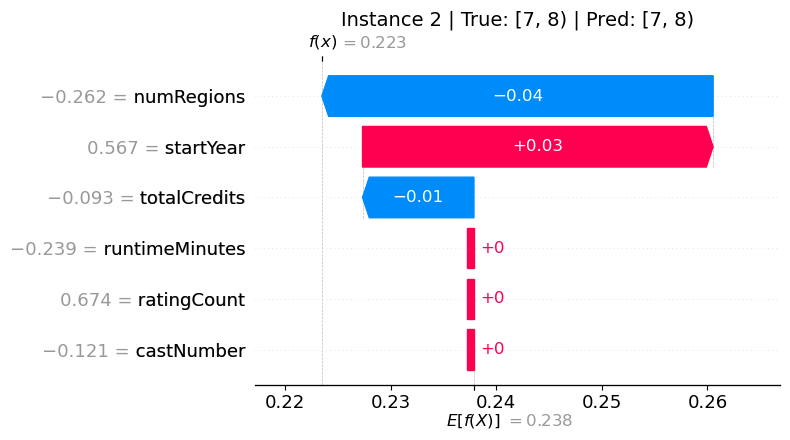

In [19]:
# --- 8. EXPLAIN INSTANCE 1 ---
instance_idx = 2 
instance = X_test_combined[instance_idx].reshape(1, -1)

# Get Predictions
pred_probs = predict_wrapper(instance)
predicted_label_idx = np.argmax(pred_probs)
true_label_string = y_test.iloc[instance_idx]
try:
    # Find which index in class_names matches the string from y_test
    true_label_idx = class_names.index(true_label_string)
except ValueError:
    # Fallback if mapping is slightly different
    true_label_idx = 0

# Calculate SHAP Values
shap_results = explainer.shap_values(instance)

# --- 9. ROBUST ALIGNMENT & PLOTTING (FINAL FIX) ---
import matplotlib.pyplot as plt

# 1. Determine how many classes SHAP actually returned
# This prevents the "Index 3 out of bounds" error
try:
    if isinstance(shap_results, list):
        # Check if our predicted index actually exists in the list
        if predicted_label_idx < len(shap_results):
            raw_vals = shap_results[predicted_label_idx]
        else:
            # Fallback to the first element if index is missing
            raw_vals = shap_results[0]
        
        # Pull the first instance [0] and flatten
        current_shap_values = np.array(raw_vals[0]).flatten()
        
    else:
        # If it's a 3D array (classes, samples, features)
        if predicted_label_idx < shap_results.shape[0]:
            current_shap_values = shap_results[predicted_label_idx, 0, :].flatten()
        else:
            current_shap_values = shap_results[0, 0, :].flatten()

    # 2. Extract correct base value (Expected Value)
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        if predicted_label_idx < len(explainer.expected_value):
            base_value = explainer.expected_value[predicted_label_idx]
        else:
            base_value = explainer.expected_value[0]
    else:
        base_value = explainer.expected_value

except Exception as e:
    print(f"Alignment warning: {e}. Falling back to basic flattening.")
    current_shap_values = np.array(shap_results).flatten()[:len(feature_names)]
    base_value = 0.5

# 3. Create Explanation Object
exp = shap.Explanation(
    values=current_shap_values[:len(feature_names)],
    base_values=float(base_value),
    data=instance.flatten()[:len(feature_names)],
    feature_names=feature_names
)

# 4. Plot with updated Title
plt.figure(figsize=(10, 8))
shap.plots.waterfall(exp, max_display=6, show=False)

# UPDATED TITLE LINE:
plt.title(f"Instance {instance_idx} | True: {class_names[true_label_idx]} | Pred: {class_names[predicted_label_idx]}", fontsize=14)

plt.tight_layout()
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

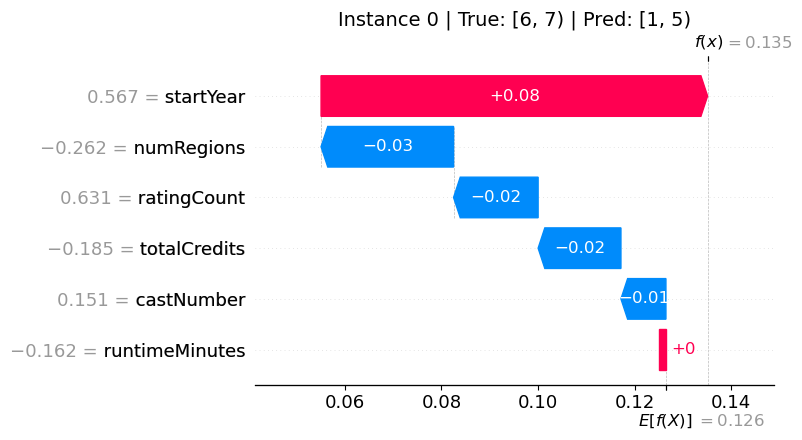

In [20]:
# --- 8. EXPLAIN INSTANCE 0 ---
instance_idx = 0 
instance = X_test_combined[instance_idx].reshape(1, -1)

# Get Predictions
pred_probs = predict_wrapper(instance)
predicted_label_idx = np.argmax(pred_probs)
true_label_string = y_test.iloc[instance_idx]
try:
    # Find which index in class_names matches the string from y_test
    true_label_idx = class_names.index(true_label_string)
except ValueError:
    # Fallback if mapping is slightly different
    true_label_idx = 0

# Calculate SHAP Values
shap_results = explainer.shap_values(instance)

# --- 9. ROBUST ALIGNMENT & PLOTTING (FINAL FIX) ---
import matplotlib.pyplot as plt

# 1. Determine how many classes SHAP actually returned
# This prevents the "Index 3 out of bounds" error
try:
    if isinstance(shap_results, list):
        # Check if our predicted index actually exists in the list
        if predicted_label_idx < len(shap_results):
            raw_vals = shap_results[predicted_label_idx]
        else:
            # Fallback to the first element if index is missing
            raw_vals = shap_results[0]
        
        # Pull the first instance [0] and flatten
        current_shap_values = np.array(raw_vals[0]).flatten()
        
    else:
        # If it's a 3D array (classes, samples, features)
        if predicted_label_idx < shap_results.shape[0]:
            current_shap_values = shap_results[predicted_label_idx, 0, :].flatten()
        else:
            current_shap_values = shap_results[0, 0, :].flatten()

    # 2. Extract correct base value (Expected Value)
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        if predicted_label_idx < len(explainer.expected_value):
            base_value = explainer.expected_value[predicted_label_idx]
        else:
            base_value = explainer.expected_value[0]
    else:
        base_value = explainer.expected_value

except Exception as e:
    print(f"Alignment warning: {e}. Falling back to basic flattening.")
    current_shap_values = np.array(shap_results).flatten()[:len(feature_names)]
    base_value = 0.5

# 3. Create Explanation Object
exp = shap.Explanation(
    values=current_shap_values[:len(feature_names)],
    base_values=float(base_value),
    data=instance.flatten()[:len(feature_names)],
    feature_names=feature_names
)

# 4. Plot with updated Title
plt.figure(figsize=(10, 8))
shap.plots.waterfall(exp, max_display=6, show=False)

# UPDATED TITLE LINE:
plt.title(f"Instance {instance_idx} | True: {class_names[true_label_idx]} | Pred: {class_names[predicted_label_idx]}", fontsize=14)

plt.tight_layout()
plt.show()